## Data Import

In [ ]:
pip install googletrans==4.0.0-rc1


In [ ]:
import re
import locale
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# from googletrans import Translator
from tqdm import tqdm
tqdm.pandas()

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = pd.read_excel("sample_data/hotel_reviews_trianon_rive_gauche.xlsx")
df.head()

,Content,Country,Score,Positive,Negative,Date
0,Rien à redire,La Réunion,Avec une note de 10,"Propre, l’emplacement, personnel et la literie...",Rien,Commentaire envoyé le 16 août 2024
1,Bien,France,"Avec une note de 7,0",Normal pour un 4 étoiles,"L'isolation phonique. On entend les voisins, s...",Commentaire envoyé le 13 septembre 2024
2,Fabuleux,France,"Avec une note de 9,0",L'emplacement le prix posé en dernière minute ...,NaN,Commentaire envoyé le 10 septembre 2024
3,Super séjour !,France,"Avec une note de 8,0",Chambre confortable et très propre. Petit déje...,NaN,Commentaire envoyé le 5 septembre 2024
4,mérite d'être bien noté surtout pour l'emplace...,Tunisie,"Avec une note de 8,0",Très bon emplacement\nBon petit déjeuner en sa...,douche vraiment petite,Commentaire envoyé le 29 août 2024


## Data Cleaning

I first convert the content of 'Date' column into a valid date format.






In [ ]:
months_map = {
    'janvier': '01', 'février': '02', 'mars': '03', 'avril': '04',
    'mai': '05', 'juin': '06', 'juillet': '07', 'août': '08',
    'septembre': '09', 'octobre': '10', 'novembre': '11', 'décembre': '12'
}

def replace_french_month(date_str):
    for french_month, month_num in months_map.items():
        if french_month in date_str:
            return date_str.replace(french_month, month_num)
    return date_str
date_value_example = df["Date"][1]
df['Date'] = df['Date'].apply(replace_french_month)
df['Date'] = df['Date'].str.extract(r'envoyé le (\d{1,2} \w+ \d{4})')[0]
df['Date'] = pd.to_datetime(df['Date'], format='%d %m %Y', errors='coerce')

commentary = f"Previous Date value : {date_value_example} \
 \nBecomes : {df['Date'][1].strftime('%Y-%m-%d')}"
print(commentary)

Previous Date value : Commentaire envoyé le 13 septembre 2024  
Becomes : 2024-09-13


### Mapping countries with associated region done with the use of text generative AI

In [ ]:
regions_mapping = {
    'La Réunion': 'Africa',
    'France': 'Europe',
    'Tunisie': 'Africa',
    'Guadeloupe': 'North America',
    'Belgique': 'Europe',
    'Finlande': 'Europe',
    'Sénégal': 'Africa',
    'Saint-Martin (Antilles françaises)': 'North America',
    'Martinique': 'North America',
    'Canada': 'North America',
    'Algérie': 'Africa',
    'Suisse': 'Europe',
    'Île Maurice': 'Africa',
    'Maroc': 'Africa',
    'Portugal': 'Europe',
    'Luxembourg': 'Europe',
    'Gabon': 'Africa',
    'Allemagne': 'Europe',
    'Polynésie française': 'Oceania',
    'Turquie': 'Asia',
    'Émirats arabes unis': 'Asia',
    'République démocratique du Congo': 'Africa',
    'Espagne': 'Europe',
    'Liban': 'Asia',
    'Brésil': 'South America',
    'Côte-d\'Ivoire': 'Africa',
    'Pays-Bas': 'Europe',
    'Corée du Sud': 'Asia',
    'États-Unis': 'North America',
    'Roumanie': 'Europe',
    'Royaume-Uni': 'Europe',
    'Irlande': 'Europe',
    'Australie': 'Oceania',
    'Afrique du Sud': 'Africa',
    'Hongrie': 'Europe',
    'Estonie': 'Europe',
    'Philippines': 'Asia',
    'Arménie': 'Asia',
    'République tchèque': 'Europe',
    'Italie': 'Europe',
    'Norvège': 'Europe',
    'Autriche': 'Europe',
    'Slovaquie': 'Europe',
    'Pologne': 'Europe',
    'Ukraine': 'Europe',
    'Nouvelle-Zélande': 'Oceania',
    'République dominicaine': 'North America',
    'Argentine': 'South America',
    'Inde': 'Asia',
    'Russie': 'Europe',
    'Albanie': 'Europe',
    'Hong Kong': 'Asia',
    'Israël': 'Asia',
    'Islande': 'Europe',
    'Lettonie': 'Europe',
    'Lituanie': 'Europe',
    'Japon': 'Asia',
    'Chine': 'Asia',
    'Géorgie': 'Asia',
    'Serbie': 'Europe',
    'Malte': 'Europe',
    'Égypte': 'Africa',
    'Singapour': 'Asia',
    'Danemark': 'Europe',
    'Chypre': 'Europe',
    'Bermudes': 'North America',
    'Iran': 'Asia',
    'Taïwan': 'Asia',
    'Croatie': 'Europe',
    'Azerbaïdjan': 'Asia',
    'Qatar': 'Asia',
    'Malaisie': 'Asia',
    'Kenya': 'Africa',
    'Biélorussie': 'Europe',
    'Mexique': 'North America',
    'Irak': 'Asia',
    'Suède': 'Europe',
    'Bahreïn': 'Asia',
    'Monténégro': 'Europe',
    'Bulgarie': 'Europe',
    'Slovénie': 'Europe',
    'Nigeria': 'Africa',
    'Paraguay': 'South America',
    'Pakistan': 'Asia',
    'Grèce': 'Europe',
    'Arabie Saoudite': 'Asia',
    'Colombie': 'South America',
    'Guatemala': 'North America',
    'Indonésie': 'Asia',
    'Oman': 'Asia',
    'Koweït': 'Asia',
    'Fidji': 'Oceania',
    'Kazakhstan': 'Asia',
    'Uruguay': 'South America',
    'Pérou': 'South America',
    'Chili': 'South America',
    'Équateur': 'South America',
    'Bolivie': 'South America',
    'Ouzbékistan': 'Asia',
    'Vénézuela': 'South America',
    'Thaïlande': 'Asia',
    'Costa Rica': 'North America',
    'Groenland': 'North America',
    'Cameroun': 'Africa',
    'Gambie': 'Africa',
    'Nouvelle-Calédonie': 'Oceania',
    'Kirghizistan': 'Asia',
    'Mongolie': 'Asia',
    'Jordanie': 'Asia',
    'Bosnie-Herzégovine': 'Europe',
    'Porto Rico': 'North America',
    'Panama': 'North America',
    'Bangladesh': 'Asia',
    'Soudan': 'Africa',
    'Turkmenistan': 'Asia',
    'Moldavie': 'Europe',
    'Îles Féroé': 'Europe',
    'Andorre': 'Europe'
}

### Figures to visualize data

In [ ]:
df["Country"].nunique()

118

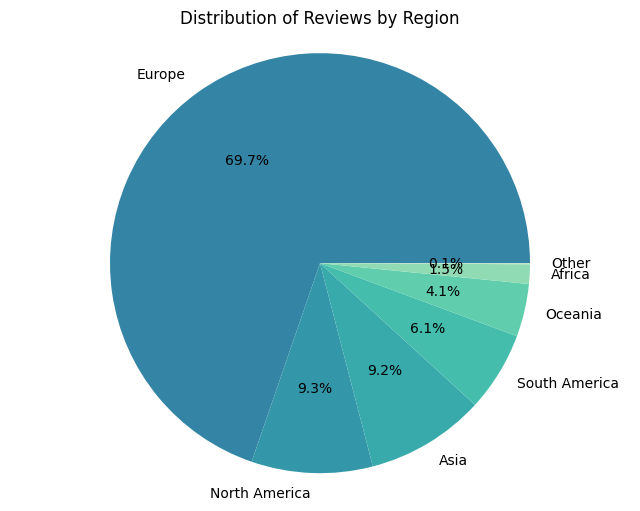

In [ ]:
df['Region'] = df['Country'].map(regions_mapping)
df['Region'].fillna('Other', inplace=True)
region_counts = df['Region'].value_counts()

palette = sns.color_palette("mako", n_colors=len(region_counts)*2)[len(region_counts):]

plt.figure(figsize=(8, 6))
plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', colors=palette)
plt.title('Distribution of Reviews by Region')
plt.axis('equal')
plt.show()


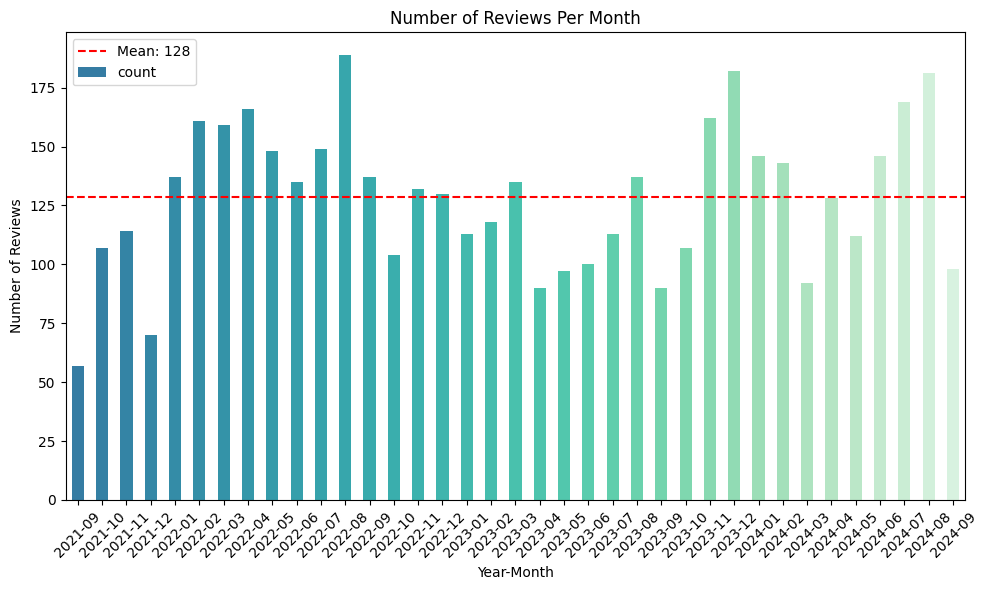

In [ ]:
df['YearMonth'] = df['Date'].dt.strftime('%Y-%m')
reviews_per_month = df['YearMonth'].value_counts().sort_index()

palette = sns.color_palette("mako", n_colors=len(reviews_per_month)*2)[len(reviews_per_month):]

plt.figure(figsize=(10, 6))
reviews_per_month.plot(kind='bar', color=palette)

mean_reviews_per_month = reviews_per_month.mean()
plt.axhline(y=mean_reviews_per_month, color='red', linestyle='--', label=f'Mean: {mean_reviews_per_month:.0f}')

plt.title('Number of Reviews Per Month')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Then I do the same for 'Score' column.

In [ ]:
score_value_example = df['Score'][1]
df['Score'] = df['Score'].str.extract(r'(\d+)')[0]
df['Score'] = pd.to_numeric(df['Score'], errors='coerce')
df['Score'] = df['Score'].astype('Int64')

commentary = f"Previous Score value : {score_value_example} \
 \nBecomes : {df['Score'][1]}"
print(commentary)

Previous Score value : Avec une note de 7,0  
Becomes : 7


The values that will be parsed are in 'Negative' column. This is why I need to translate all the rows in a same language. Here, we will chose English.

In [ ]:
import pandas as pd
from googletrans import Translator
from time import sleep

df.dropna(subset=['Negative'], inplace=True)
df = df[~df['Negative'].str.lower().isin(['rien', 'ras'])]

translator = Translator()

def translate_text(text, dest='en'):
    sleep(1) # 1-second delay to deal with the limited amount of requests of Translator() object.
    try:
        translation = translator.translate(text, dest=dest)
        return translation.text
    except Exception as e:
        print(f"Erreur lors de la traduction : {e}")
        return text

df['Translated_Neg'] = df['Negative'].progress_apply(lambda x: translate_text(x, dest='en'))

100%|██████████| 2052/2052 [36:28<00:00,  1.07s/it]


In a second term, I clean the text to remove unnecessary punctuation in order to simplify the analysis.

I additionnaly remove reviews that contain 'Nothing' word because they are useless.




In [ ]:
df = df[~df['Translated_Neg'].str.contains('nothing', case=False, na=False)]

def clean_text(text):
    text = text.lower()
    text = text.replace("’", " ")
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    return text

df['Translated_Neg'] = df['Translated_Neg'].astype(str)

df['Clean_Neg'] = df['Translated_Neg'].apply(clean_text)

Here, I apply tokenization and lemmatization. A lemmatization is the process of reducing words to their base form so that variations of a word are grouped in a single word (ex: 'rooms' will become 'room').

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['Clean_Neg'] = df['Clean_Neg'].apply(preprocess_text)

df['Clean_Neg'] = df['Clean_Neg'].replace("nan", np.nan)
df.dropna(subset=['Clean_Neg'], inplace=True)

## Data Analysis

In [ ]:
df = pd.read_excel("sample_data/hotel_reviews_trianon_rive_gauche_cleaned.xlsx")
df_raw = pd.read_excel("sample_data/hotel_reviews_trianon_rive_gauche.xlsx")
df.dropna(subset=['Clean_Neg'], inplace=True)

### Most frequent words

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Clean_Neg'])

terms = tfidf_vectorizer.get_feature_names_out()

sum_tfidf = tfidf_matrix.sum(axis=0)
words_freq = [(word, sum_tfidf[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

top_words = pd.DataFrame(words_freq[:20], columns=['word', 'frequency'])
top_words.head(20)

,word,frequency
0,room,170.423305
1,small,138.753593
2,bathroom,101.248501
3,breakfast,58.220401
4,little,52.689142
5,hotel,50.220417
6,shower,46.133373
7,elevator,39.899833
8,old,38.469276
9,bit,37.293957


### Clustering reviews using k-means algorithm

In [ ]:
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

df['cluster'] = kmeans.labels_

for i in range(num_clusters):
    print(f"Cluster {i}:")
    print(df[df['cluster'] == i]['Clean_Neg'].head(5))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0:
0     sound insulation hear neighbor especially step...
5                           bottle water made available
7     blocked sink therefore limited use shower paro...
11    small bathroom replace old bathtub shoe shower...
13                                         lighting low
Name: Clean_Neg, dtype: object
Cluster 1:
8                               shower little narrow
37                               shower little small
56        bathroom little poorly arranged hey detail
71               bad shower shower read little small
93    egg morning little calf otherwise rest perfect
Name: Clean_Neg, dtype: object
Cluster 2:
21     dilapidated bathroom
34      narrowness bathroom
50    dilapidation bathroom
82           small bathroom
85           small bathroom
Name: Clean_Neg, dtype: object
Cluster 3:
1            really small shower
19    shower small remains paris
30            small shower cabin
36                  small shower
41                    small room
Name: Clean_N

<ipython-input-25-924f5abb71af>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='Score', data=cluster_scores, palette=palette)


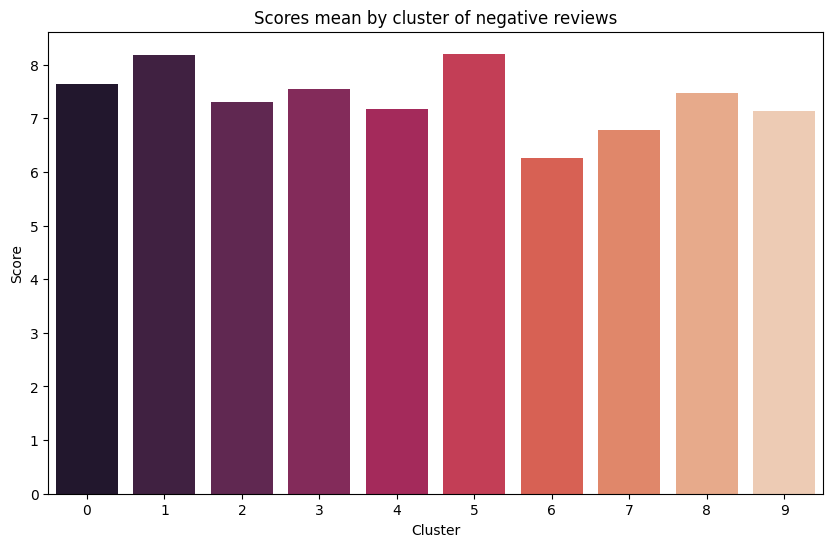

,word,avg_score
0,room,6.925522
1,small,7.041431
2,bathroom,6.793970
3,breakfast,6.680556
4,little,7.976190
5,hotel,6.261044
6,shower,7.016760
7,elevator,7.284615
8,old,6.098291
9,bit,7.967742


In [ ]:
cluster_scores = df.groupby('cluster')['Score'].mean().reset_index()
palette = sns.color_palette("rocket", 10)
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='Score', data=cluster_scores, palette=palette)
plt.title("Scores mean by cluster of negative reviews")
plt.xlabel("Cluster")
plt.ylabel("Score")
plt.show()

word_scores = []
for word, freq in words_freq[:20]:
    word_in_reviews = df['Clean_Neg'].str.contains(word)
    avg_score = df[word_in_reviews]['Score'].mean()
    word_scores.append((word, avg_score))

word_scores_df = pd.DataFrame(word_scores, columns=['word', 'avg_score'])
word_scored_df = word_scores_df.sort_values(by='avg_score', ascending=False)
word_scores_df.head(len(word_scores_df))


### In-depth Analysis: Why Do the Words 'Tiny,' 'Little,' and 'Small' Appear So Frequently?

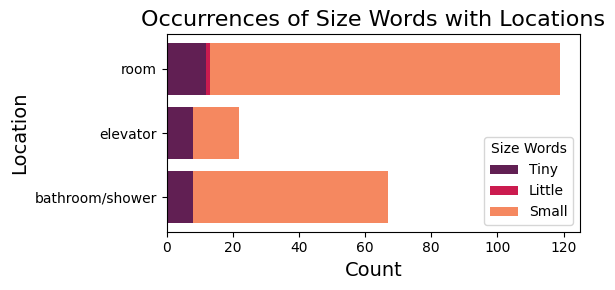

In [ ]:
size_words = ['tiny', 'little', 'small']
location_words = ['elevator', 'bathroom', 'shower', 'room']

def count_word_combinations(text, size_word, location_word):
    pattern = re.compile(r'\b' + size_word + r'\s+' + location_word + r'\b', re.IGNORECASE)
    return len(pattern.findall(text))

word_counts = {size_word: {'bathroom/shower': 0, 'elevator': 0, 'room': 0} for size_word in size_words}

for review in df['Clean_Neg']:
    for size_word in size_words:
        for location_word in location_words:
            if location_word in ['bathroom', 'shower']:
                word_counts[size_word]['bathroom/shower'] += count_word_combinations(review, size_word, location_word)
            else:
                word_counts[size_word][location_word] += count_word_combinations(review, size_word, location_word)

word_counts_df = pd.DataFrame(word_counts)

palette = sns.color_palette("rocket", 3)

locations = word_counts_df.index
tiny_counts = word_counts_df['tiny']
little_counts = word_counts_df['little']
small_counts = word_counts_df['small']

plt.figure(figsize=(6, 3))

plt.barh(locations, tiny_counts, color=palette[0], label='Tiny')
plt.barh(locations, little_counts, left=tiny_counts, color=palette[1], label='Little')
plt.barh(locations, small_counts, left=tiny_counts + little_counts, color=palette[2], label='Small')

plt.title('Occurrences of Size Words with Locations', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Location', fontsize=14)
plt.legend(title='Size Words')
plt.tight_layout()

plt.show()


We observe that the amount of reviews complaining on the smallness concern essentially the room, then the bathroom and we have finally some complains about the elevator.

In [ ]:
word_counts_df_t = word_counts_df.T
total_bathroom = word_counts_df_t['bathroom/shower'].sum()
total_elevator = word_counts_df_t['elevator'].sum()
total_room = word_counts_df_t['room'].sum()

total_list = pd.Series([total_bathroom, total_elevator, total_room], index=word_counts_df_t.columns)
word_counts_df_t.loc['Total'] = total_list
word_counts_df_t.head()

,bathroom/shower,elevator,room
tiny,8,8,12
little,0,0,1
small,59,14,106
Total,67,22,119


In [ ]:
size_words = ['tiny', 'little', 'small']
location_word = 'room'
pattern = r'\b(?:' + '|'.join(size_words) + r')\b.*\b' + location_word + r'\b'
matching_reviews = df[df['Translated_Neg'].str.contains(pattern, case=False, na=False)]

In [ ]:
review_examples = f"Here are 3 examples of reviews that complain on the size of the room : \
\n\t- '{matching_reviews['Translated_Neg'][6]}' \
\n\t- '{matching_reviews['Translated_Neg'][215]}' \
\n\t- '{matching_reviews['Translated_Neg'][97]}' \
"
print(review_examples)

Here are 3 examples of reviews that complain on the size of the room : 
	- 'The tiny room !!!!Impossible to enter 2 suitcases!' 
	- 'The very small room despite the choice of a superior room.The dilapidated air conditioning which does not cool' 
	- 'Very small room, 140cm bed and bathroom too and a little dated for a fairly high price' 


The word 'little' is used in order to measure the degree of complaint

In [ ]:
pattern = r'\blittle\b \bsmall\b'
df_little_small = df[df['Clean_Neg'].str.contains(pattern, case=False, na=False)]
print(f"Number of reviews containing 'little' with 'small': {df_little_small.shape[0]}")
df_little_small['Translated_Neg'].head()

Number of reviews containing 'little' with 'small': 29


,Translated_Neg
37,The shower a little small
71,Bad shower of the shower and reads a little small
95,Room: a little small\nBathroom: Ditto - Provid...
125,A little small bathroom with toilet in it.\nDi...
134,A little small but very functional bathroom


### Reviews by country

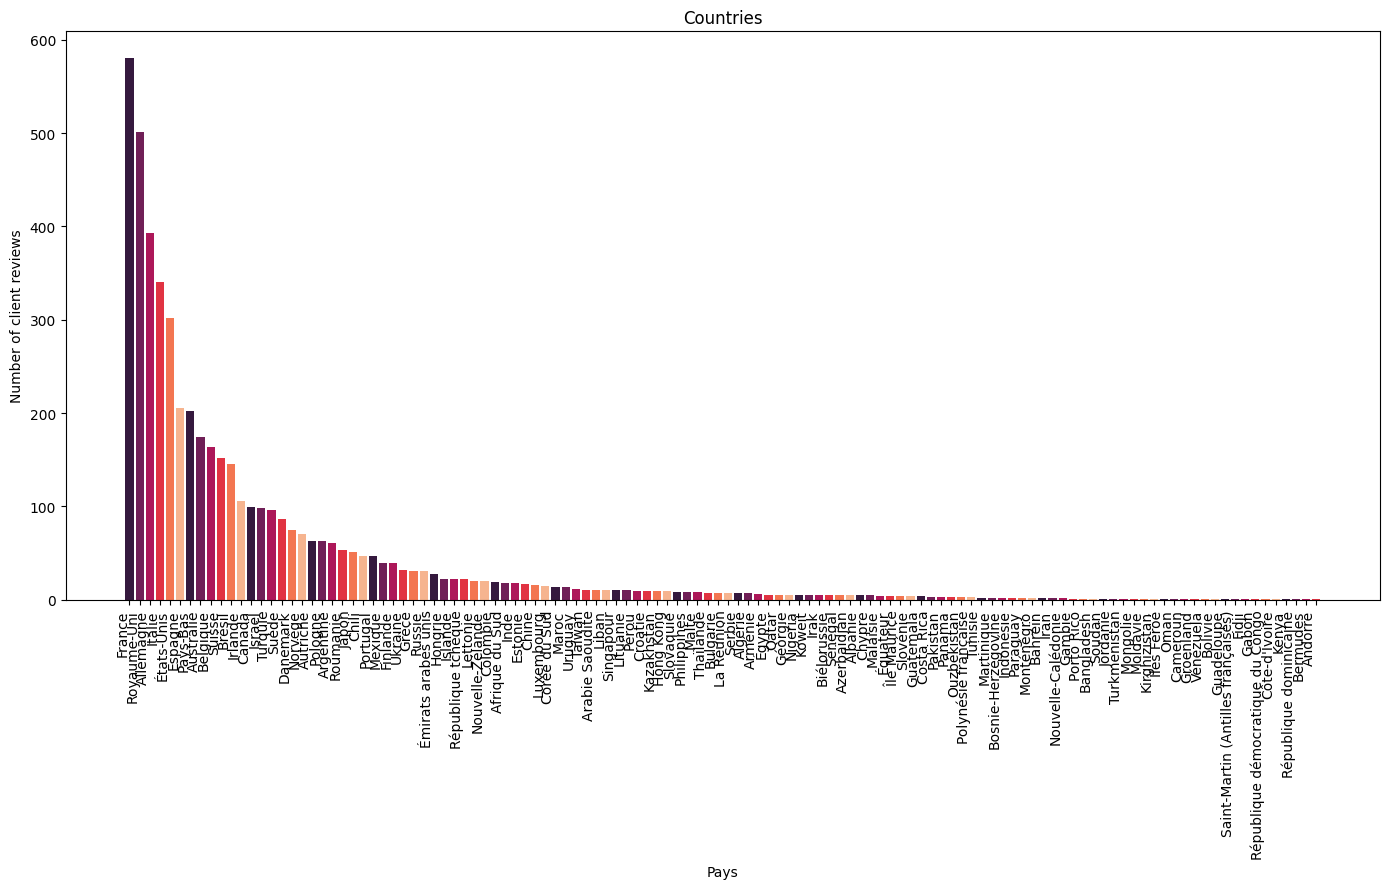

In [ ]:
country_count = df_raw['Country'].value_counts()
palette = sns.color_palette("rocket")
plt.figure(figsize=(14, 9))
plt.bar(country_count.index, country_count.values, color=palette)
plt.xlabel('Pays')
plt.ylabel('Number of client reviews')
plt.title('Countries')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


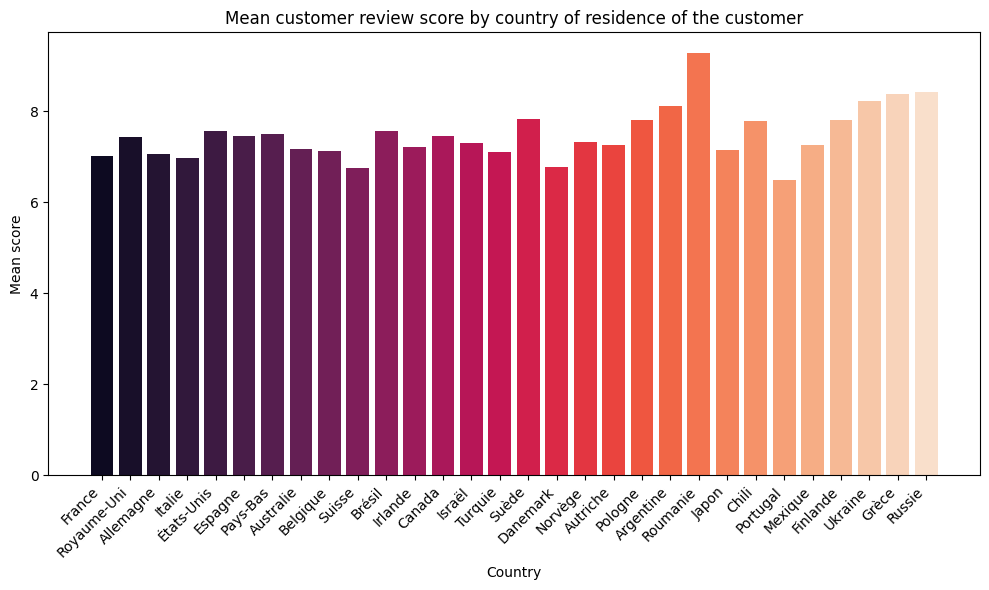

In [ ]:
min_amount_review_country = country_count[country_count > 30].index
df_country = df[df['Country'].isin(min_amount_review_country)]

country_score = df_country.groupby('Country')['Score'].mean()

country_score = country_score.loc[min_amount_review_country.intersection(country_score.index)]
palette = sns.color_palette("rocket", len(country_score))

plt.figure(figsize=(10, 6))
plt.bar(country_score.index, country_score.values, color=palette)
plt.xlabel('Country')
plt.ylabel('Mean score')
plt.title('Mean customer review score by country of residence of the customer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
country_score_sorted = country_score.sort_values(ascending=True)
print(f"3 countries with the weakest mean scores : \n{country_score_sorted.head(3)}")


3 countries with the weakest mean scores : 
Country
Portugal    6.500000
Suisse      6.746032
Danemark    6.766667
Name: Score, dtype: float64


In [ ]:
portuguese_reviews = df[df['Country'] == 'Portugal']['Translated_Neg']
for review in portuguese_reviews:
  print(review)


The reception staff is not very professional.
The room is tiny and does not have a storage cabinet.
The bed when we arrive was not very cleaned, with some hair and stains on the sheets
Difficult to stabilize the shower temperature
We thought the room was a little small yet it didn't interfere our experience as we walked around the city most of the day.
The air conditioner didn’t work very well and the city was hot in those days. They have to change all the fridges, terrible, didn’t work too.
Bedroom looked really tired and dated. Bathroom is extremely small and tub looking dirty and old needing to be replaced. Also super small and view was to a wall and airconditioner extractor! Also requested 4 days before my check in and during my stay and check out for the hotel invoice to be done with my company details and fiscal number and no one was Trained for that! Still waiting for that invoice until today! 5 days after and after severall messages through Booking to the Hotel with NO RESPONSE

In [ ]:
df.to_excel("sample_data/hotel_reviews_trianon_rive_gauche_cleaned.xlsx")